### (week4) Home Credit Default Risk

>`Cf.`
> + [Home-Credit-Default-Risk - github](https://github.com/rishabhrao1997/Home-Credit-Default-Risk/blob/main/EDA%20-%20Home%20Credit%20Default.ipynb)
> + [HOME CREDIT DEFAULT RISK — An End to End ML Case Study — PART 1: Introduction and EDA - medium](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)
> + [HOME CREDIT DEFAULT RISK — An End to End ML Case Study — PART 1: Introduction and EDA](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)
> + [HOME CREDIT DEFAULT RISK — An End to End ML Case Study — PART 2: Feature Engineering and Modelling](https://medium.com/thecyphy/home-credit-default-risk-part-2-84b58c1ab9d5)

> ```point.```
> Supervised Classfication

##### - import

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings # 実行に関係ない警告を無視
warnings.filterwarnings(action="ignore")

# algorithm
from sklearn.neighbors import KNeighborsClassifier # 最近傍法
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.svm import SVC # SVM 
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from xgboost import XGBClassifier #XGBoost
from lightgbm import LGBMClassifier #LightGBM

# evaluations
from sklearn.metrics import accuracy_score # 正解率
from sklearn.metrics import precision_score # 適合率
from sklearn.metrics import recall_score # 再現率
from sklearn.metrics import f1_score # F値
from sklearn.metrics import confusion_matrix # 混合行列

# visualization
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

#### 【問題1】コンペティション内容の確認
> + (a) 何を学習し、何を予測するのか
> + (b) どのようなファイルを作りKaggleに提出するか
> + (c) 提出されたものはどういった指標値で評価されるのか

(a): Targetになりうるクライアントの返済能力を予測

(b): [提出ファイル - kaggle](https://www.kaggle.com/c/home-credit-default-risk/overview/evaluation)で指定されているファイルを作成して提出

(c): 予測された確率と観察されたターゲットの間の[ROC曲線](https://ja.wikipedia.org/wiki/%E5%8F%97%E4%BF%A1%E8%80%85%E6%93%8D%E4%BD%9C%E7%89%B9%E6%80%A7)の下の領域

#### 【問題2】学習と検証
> データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。

> `memo`
> Kagglerは最低限のデータセットでSubmitしてみて、Scoreがどの程度かを検証したりするそう。

##### - Dataset

In [6]:
train_raw = pd.read_csv('input/application_train.csv')
test_raw = pd.read_csv('input/application_test.csv')
print('The size of the train data :', train_raw.shape)
print('The size of the test data :', test_raw.shape)

train_mid = train_raw.copy()
train_mid['train_or_test'] = 'train'

test_mid = test_raw.copy()
test_mid['train_or_test'] = 'test'
test_mid['TARGET'] = 0.5

alldata = pd.concat([train_mid, test_mid], sort=False, axis=0).reset_index(drop=True)
print('The size of the alldata data:', alldata.shape)

The size of the train data : (307511, 122)
The size of the test data : (48744, 121)
The size of the alldata data: (356255, 123)


In [7]:
train_mid.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [8]:
test_mid.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test,TARGET
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,test,0.5
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,test,0.5
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0.0,0.0,0.0,0.0,1.0,4.0,test,0.5
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,test,0.5
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,test,0.5


In [9]:
alldata

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,0.5,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,test
356251,456222,0.5,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,test
356252,456223,0.5,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,test
356253,456224,0.5,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,test


### （問題３まで、NaN全部消しバージョン）

##### - EDA / Preprocessing

<AxesSubplot:>

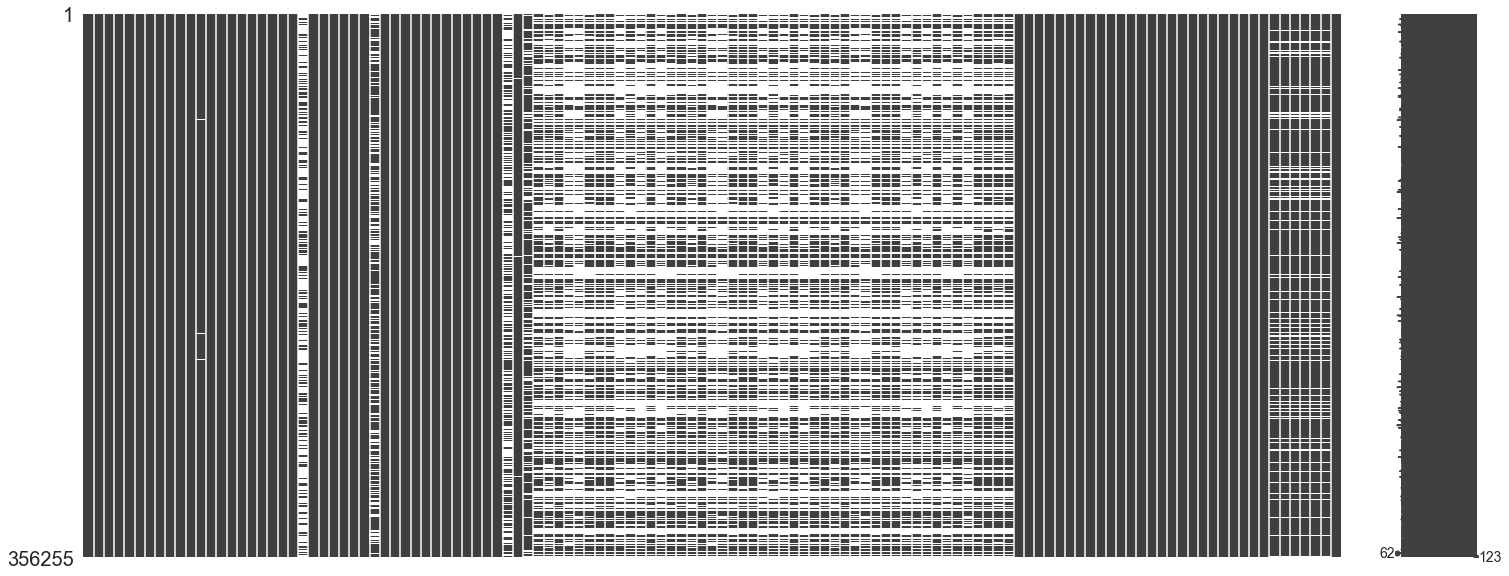

In [10]:
# 欠損データの分布確認
msn.matrix(alldata)

In [17]:
# 欠損データall除去
alldata = alldata.dropna(how="any")

(10341, 238)
SK_ID_CURR                   0
TARGET                       0
CNT_CHILDREN                 0
AMT_INCOME_TOTAL             0
AMT_CREDIT                   0
                            ..
WALLSMATERIAL_MODE_Wooden    0
EMERGENCYSTATE_MODE_No       0
EMERGENCYSTATE_MODE_Yes      0
train_or_test_test           0
train_or_test_train          0
Length: 238, dtype: int64


<AxesSubplot:>

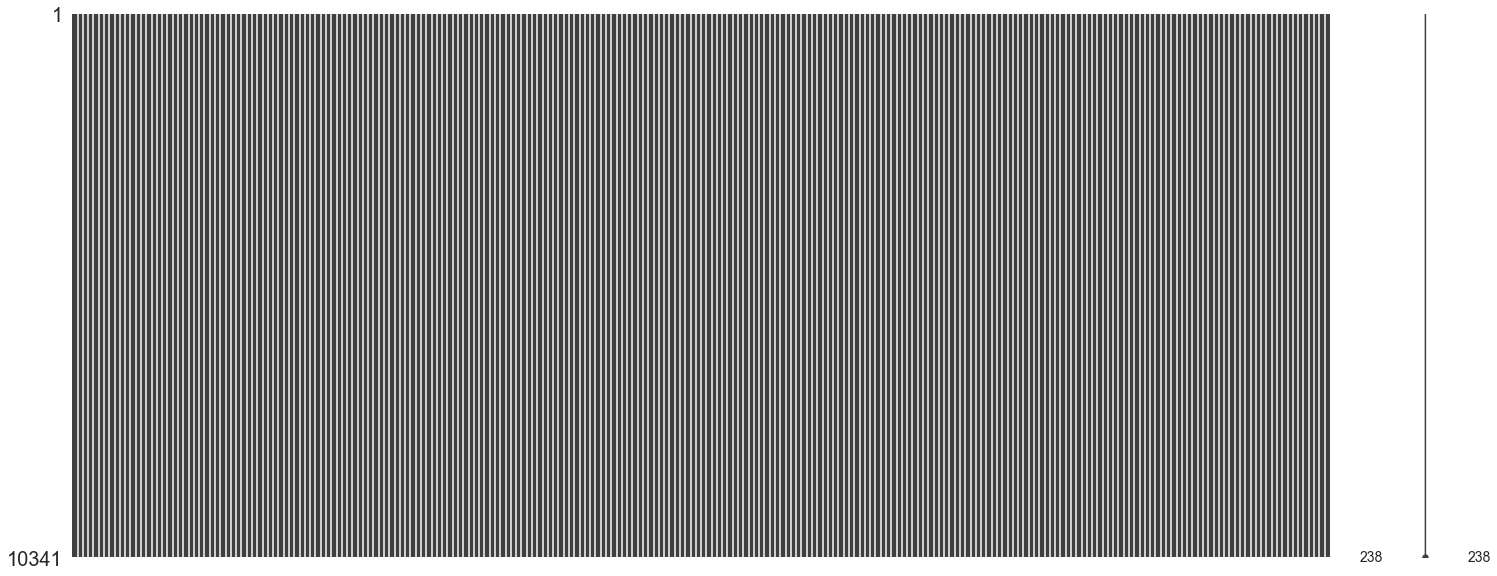

In [124]:
print(alldata.shape)
print(alldata.isnull().sum())
msn.matrix(alldata)

In [36]:
# オブジェクト型を全て Label-Encoding
alldata.dtypes[alldata.dtypes == object]

NAME_CONTRACT_TYPE            object
CODE_GENDER                   object
FLAG_OWN_CAR                  object
FLAG_OWN_REALTY               object
NAME_TYPE_SUITE               object
NAME_INCOME_TYPE              object
NAME_EDUCATION_TYPE           object
NAME_FAMILY_STATUS            object
NAME_HOUSING_TYPE             object
OCCUPATION_TYPE               object
WEEKDAY_APPR_PROCESS_START    object
ORGANIZATION_TYPE             object
FONDKAPREMONT_MODE            object
HOUSETYPE_MODE                object
WALLSMATERIAL_MODE            object
EMERGENCYSTATE_MODE           object
train_or_test                 object
dtype: object

In [40]:
alldata = pd.get_dummies(alldata)

In [41]:
alldata.dtypes[alldata.dtypes == object]

Series([], dtype: object)

In [45]:
alldata

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,train_or_test_test,train_or_test_train
71,100083,0.0,0,103500.0,573628.5,24435.0,463500.0,0.009657,-15406,-892,...,0,0,0,0,1,0,1,0,0,1
124,100145,0.0,1,202500.0,260725.5,16789.5,198000.0,0.018850,-16282,-4375,...,0,0,0,1,0,0,1,0,0,1
152,100179,0.0,0,202500.0,675000.0,53329.5,675000.0,0.031329,-11375,-2311,...,0,1,0,0,0,0,1,0,0,1
161,100190,0.0,0,162000.0,263686.5,24781.5,238500.0,0.022625,-13972,-4472,...,0,0,0,1,0,0,1,0,0,1
255,100295,1.0,1,225000.0,1019205.0,31032.0,774000.0,0.072508,-11356,-602,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356139,455243,0.5,1,112500.0,252531.0,26005.5,234000.0,0.016612,-10205,-2038,...,0,0,0,0,1,0,1,0,1,0
356181,455607,0.5,0,387000.0,350415.0,25051.5,292500.0,0.025164,-20876,-4409,...,0,0,0,0,1,0,1,0,1,0
356193,455703,0.5,1,450000.0,790830.0,57676.5,675000.0,0.035792,-9952,-1437,...,0,0,0,0,1,0,1,0,1,0
356218,455940,0.5,0,202500.0,225000.0,19242.0,225000.0,0.010006,-10159,-632,...,0,0,0,0,1,0,1,0,1,0


In [76]:
# 最初に統合したtrainとtestを分離
train_feature = alldata[alldata['train_or_test_train']==1]
test_feature = alldata[alldata['train_or_test_train']==0]
train_target = train_feature["TARGET"]
print("train: {}".format(train_feature.shape))
print("test: {}".format(test_feature.shape))

X_train, X_test, y_train, y_test = train_test_split(train_feature, train_target, test_size=0.2, random_state=0)
display(X_train)

train: (8602, 238)
test: (1739, 238)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,train_or_test_test,train_or_test_train
16299,119008,0.0,2,270000.0,417024.0,16447.5,360000.0,0.046220,-11249,-1427,...,0,0,0,1,0,0,1,0,0,1
193098,323922,0.0,0,675000.0,2085120.0,72607.5,1800000.0,0.072508,-12900,-2212,...,0,0,0,0,0,0,1,0,0,1
198819,330513,0.0,1,180000.0,792346.5,26316.0,684000.0,0.007020,-13684,-1592,...,0,0,0,0,1,0,1,0,0,1
286596,431938,0.0,0,157500.0,343800.0,13090.5,225000.0,0.007305,-19313,-8118,...,0,0,0,0,1,0,1,0,0,1
244768,383303,0.0,0,450000.0,810000.0,40500.0,810000.0,0.046220,-18327,-3917,...,0,1,0,0,0,0,1,0,0,1


##### - Baseline

In [84]:
ratio = y_train.sum() / len(y_train)
print(f'Target rate:{ratio}')
print(f'base line accuracy: {1 - ratio}')

Target rate:0.05943903502397907
base line accuracy: 0.9405609649760209


##### -Normalize

In [77]:
#標準化
sts = StandardScaler()
sts.fit(X_train, y_train)
X_train_norm = sts.transform(X_train)

##### -Machine Learning

In [82]:
# ロジスティック回帰
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_ev = evaluations(y_test, y_pred, "macro")

In [98]:
# ランダムフォレスト
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
rfc_ev = evaluations(y_test, y_pred, "macro")

##### - Evaliation

In [80]:
def evaluations(test, predict, average):
    accuracy = accuracy_score(test, predict)
    precision = precision_score(test, predict, average=average)
    recall = recall_score(test, predict, average=average)
    f1 = f1_score(test, predict, average=average)
    evaluations = {
        "正解率" : round(accuracy, 3), 
        "適合率" : round(precision, 3),
        "再現率" : round(recall, 3), 
        "F値" : round(f1, 3)
    }
    return evaluations

In [99]:
pd.DataFrame([logreg_ev, rfc_ev], index=["ロジスティック回帰", "ランダムフォレスト"])

,正解率,適合率,再現率,F値
ロジスティック回帰,0.932,0.466,0.500,0.482
ランダムフォレスト,0.997,0.998,0.979,0.988


試しにRondomforestの`feature_importances_`を見てみる

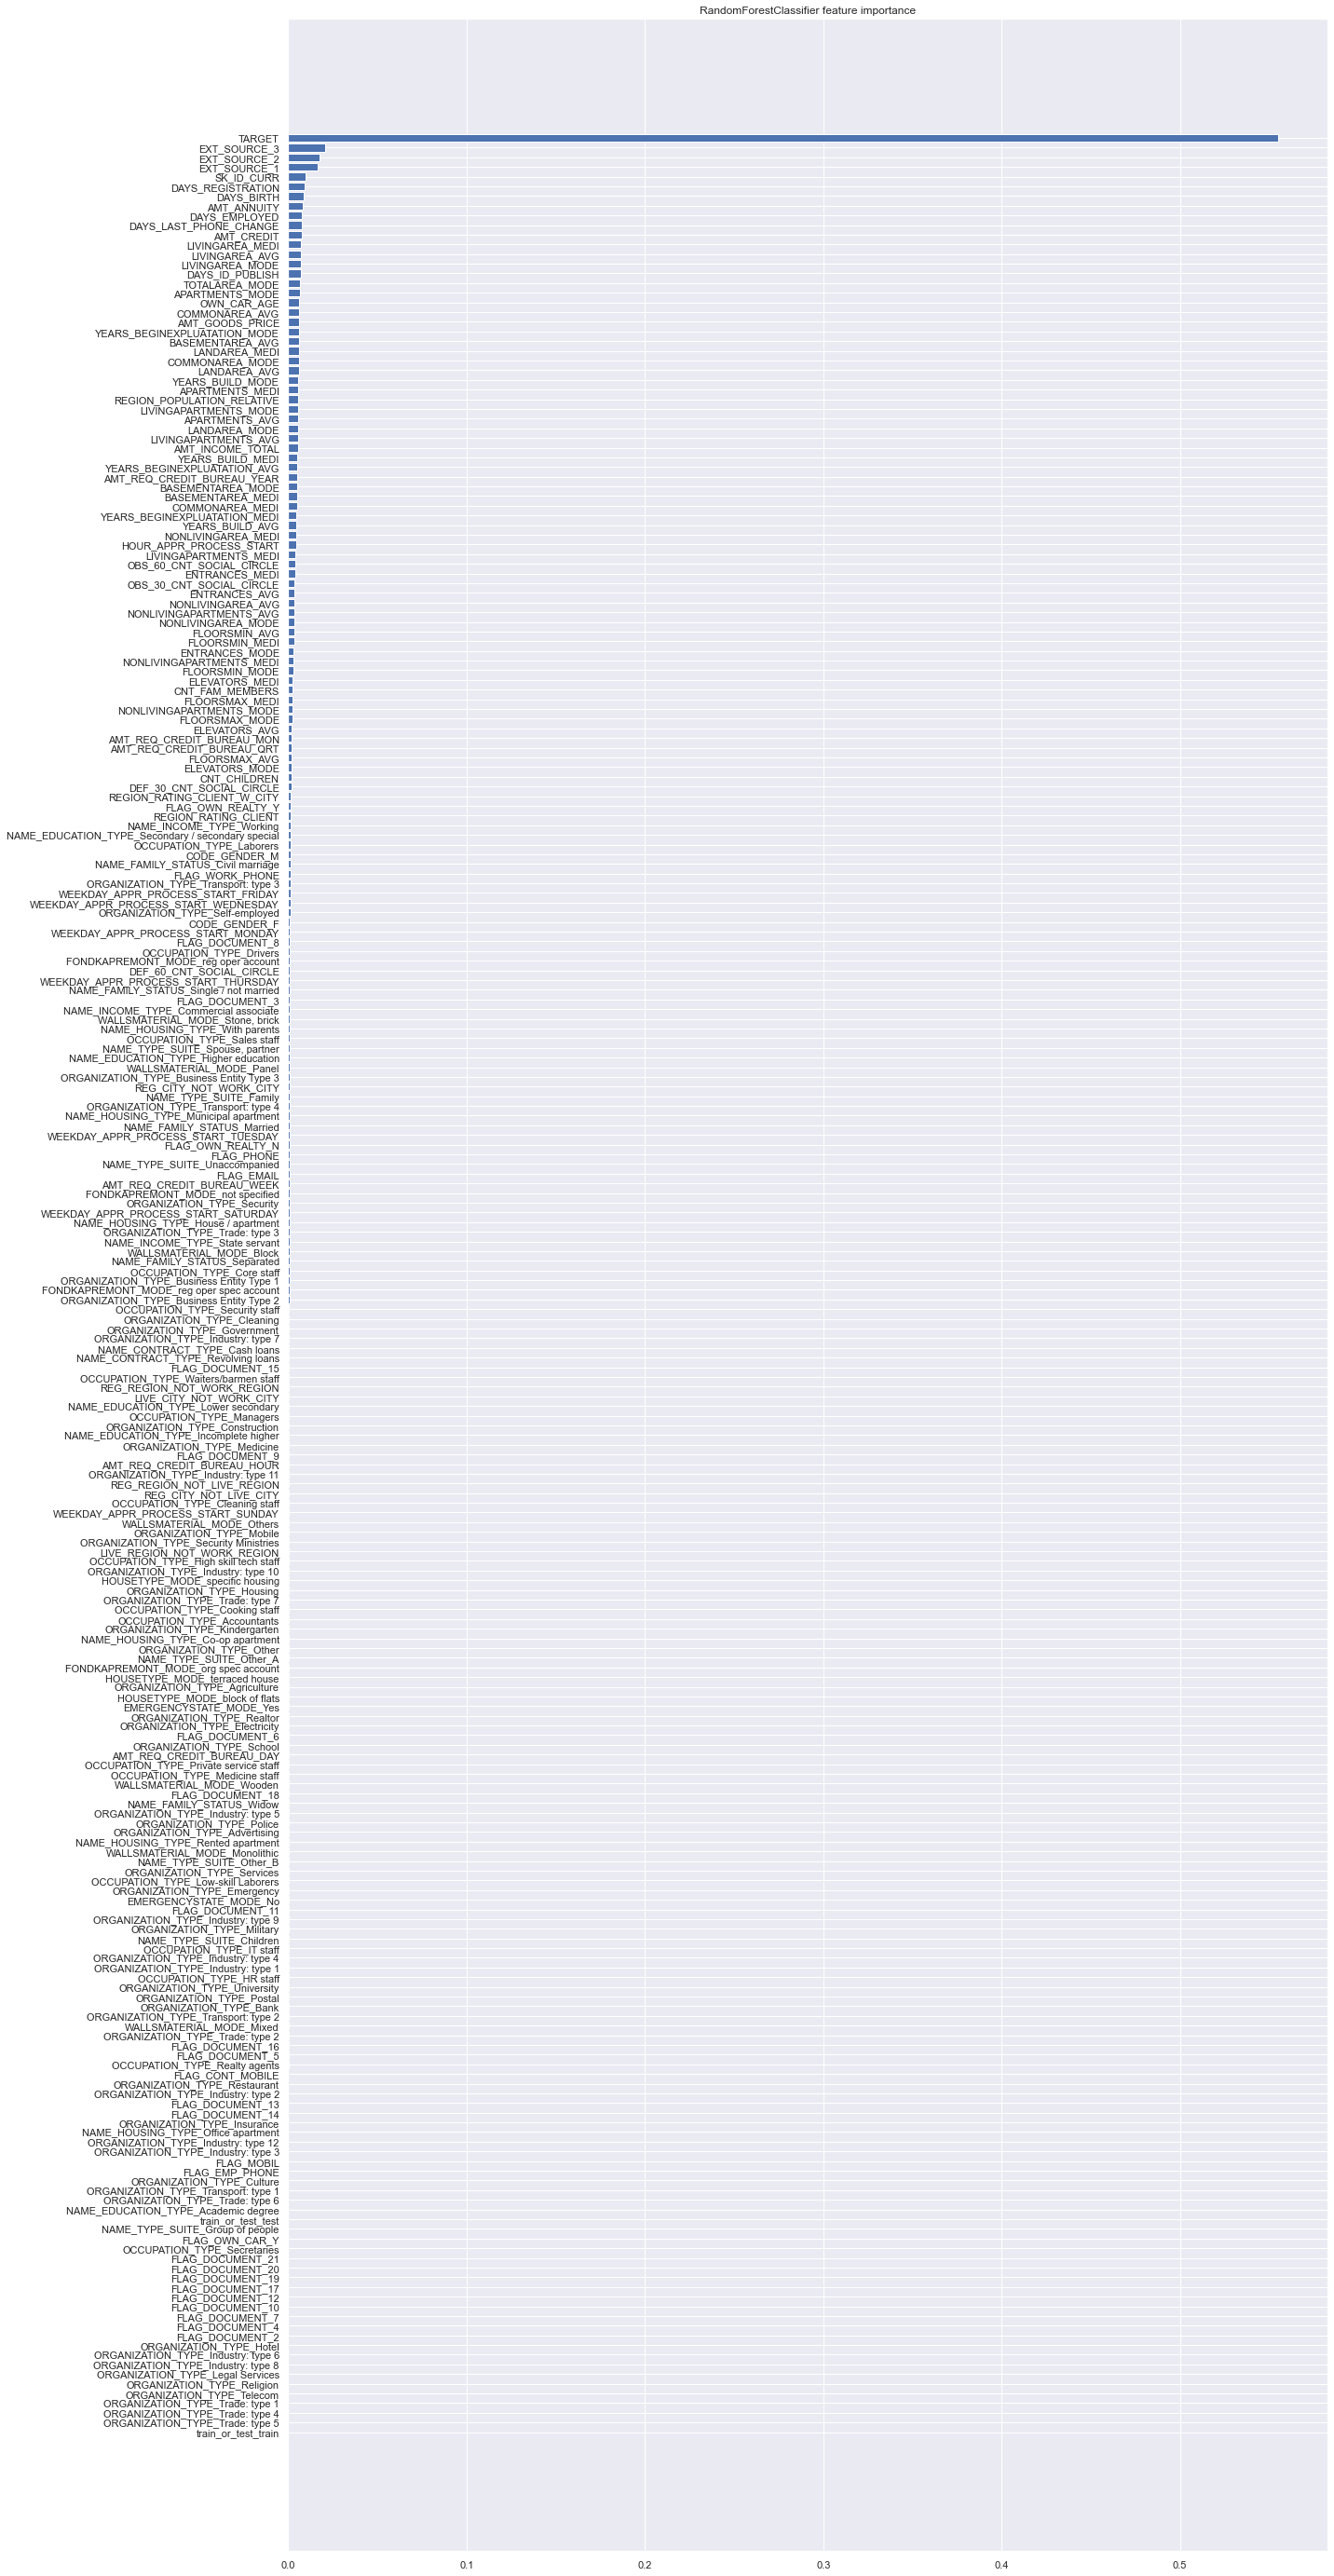

In [121]:
rfc.fit(X_train, y_train)
# n = rfc.feature_importances_
n = np.argsort(rfc.feature_importances_) # 数列の順位的なの返す
x = X_train.columns[n]
y = rfc.feature_importances_[n]

plt.figure(figsize=(20, 50))
plt.barh(x, y, label="Rondom Forest Classfire")
plt.title('RandomForestClassifier feature importance')
plt.show()

#### 【問題3】テストデータに対する推定
> テストデータ（`application_test.csv`）に対して推定を行い、Kaggleに提出を行ってください。

In [128]:
test_feature

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,train_or_test_test,train_or_test_train
307526,100107,0.5,0,180000.0,296280.0,21690.0,225000.0,0.032561,-13563,-1007,...,0,0,0,0,1,0,1,0,1,0
307529,100128,0.5,1,225000.0,431280.0,23526.0,360000.0,0.025164,-10962,-1883,...,0,0,0,1,0,0,1,0,1,0
307584,100561,0.5,0,180000.0,67500.0,8140.5,67500.0,0.015221,-11819,-2612,...,0,0,0,1,0,0,1,0,1,0
307597,100699,0.5,1,225000.0,323460.0,23134.5,270000.0,0.020246,-13444,-1659,...,0,0,0,1,0,0,1,0,1,0
307613,100770,0.5,0,202500.0,697500.0,33687.0,697500.0,0.015221,-8819,-852,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356139,455243,0.5,1,112500.0,252531.0,26005.5,234000.0,0.016612,-10205,-2038,...,0,0,0,0,1,0,1,0,1,0
356181,455607,0.5,0,387000.0,350415.0,25051.5,292500.0,0.025164,-20876,-4409,...,0,0,0,0,1,0,1,0,1,0
356193,455703,0.5,1,450000.0,790830.0,57676.5,675000.0,0.035792,-9952,-1437,...,0,0,0,0,1,0,1,0,1,0
356218,455940,0.5,0,202500.0,225000.0,19242.0,225000.0,0.010006,-10159,-632,...,0,0,0,0,1,0,1,0,1,0


In [151]:
X_test = test_feature.values # (1739, 238)

In [225]:
# ロジスティック回帰
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train, y_train) #(6881, 238) (6881, )
logreg_pred = logreg.predict_proba(X_test)

In [226]:
# ランダムフォレスト
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict_proba(X_test)

#### - submit

In [241]:
a = pd.DataFrame([logreg_pred[:,1]]).T

In [242]:
b = pd.DataFrame([test_feature.values[:,0]]).T

In [247]:
submit = pd.concat([b, a], axis=1)
submit = submit.rename(columns={0 : "SK_ID_CURR", 1 : "TARGET" })
submit.to_csv('output/demo_logreg.csv', index=False)

#### 【問題4】特徴量エンジニアリング
>     精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。
>        - どの特徴量を使うか
>        - どう前処理をするか
>     何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。

In [ ]:
# Count-up NaN

nan = alldata.isnull().sum(axis=0).reset_index()
nan.columns = ["name", "count"]
nan["ratio"] = (nan["count"] / alldata.shape[0])*100
nan = nan[nan["count"] > 0].sort_values(by="ratio")
nan["usabilty"] = np.where(nan["ratio"] > 20, "Discard", "Keep")  
nan

In [ ]:
# Plotting NaN

plt.figure(figsize=(15, 6))
sns.barplot(x=nan["name"], y=nan["ratio"])
plt.xticks(rotation=80)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

In [ ]:
drop_list = nan[nan["usabilty"]=="Discard"]["name"].values.tolist()
alldata = alldata.drop(drop_list, axis=1)
# alldata

In [ ]:
msn.matrix(alldata)

In [ ]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = alldata.corr("pearson")
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
# 関係値の低い特徴量のカラム名をリスト化
dlop_list = []


##### - Baseline
> (精度の基準となるモデル)

In [ ]:
# 最初に統合したtrainとtestを分離
train = alldata.query('train_or_test == "train"')
test = alldata.query('train_or_test == "test"')

# ターゲット変数と、学習に不要なカラムを定義
target_col = 'Target_merge'
drop_col = [drop_list]

# 学習に必要な特徴量のみを保持
train_feature = train.drop(columns=drop_col)
test_feature = test.drop(columns=drop_col)
train_tagert = train[target_col]

# trainデータを分割
X_train, X_test, y_train, y_test = train_test_split(
    train_feature, train_tagert, test_size=0.2, random_state=0, stratify=train_tagert)

In [ ]:
# trainから頻度に応じて単純なモデルを作る場合
survive_rate = y_train.sum()/len(y_train)
print(f'survive rate:{survive_rate}')
print(f'base line accuracy: {1 - survive_rate}')

##### - Normalize

In [ ]:
#標準化
sts = StandardScaler()
sts.fit(X_train, y_train)
X_train_norm = sts.transform(X_train)

##### - Machine Leaning

In [ ]:
# LogisticRegression
logreg = LogisticRegression()
logreg = logreg.fit(train_feature, train_tagert)

In [ ]:
# RandomForest
rfc = RandomForestClassifier()
rfc = rfc.fit(train_feature, train_tagert)

In [ ]:
# SVC
svc = SVC()
svc = svc.fit(train_feature, train_tagert)

In [ ]:
# XGBoost
xgb = XGBClassifier()
xgb = xgb.fit(train_feature, train_tagert)

In [ ]:
# LightGBM
lgb = LGBMClassifier()
lgb = lgb.fit(train_feature, train_tagert)

In [ ]:
# LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_feature, train_tagert)
# RandomForest
rfc = RandomForestClassifier()
rfc.fit(train_feature, train_tagert)
# XGBoost
xgb = XGBClassifier()
xgb.fit(train_feature, train_tagert)
# LightGBM
lgb = LGBMClassifier()
lgb.fit(train_feature, train_tagert)
# SVC
svc = SVC()
svc.fit(train_feature, train_tagert)

# 推論
pred = {
    'rfc': rfc.predict(test_feature),
    'xgb': xgb.predict(test_feature),
    'lgb': lgb.predict(test_feature),
    'logreg': logreg.predict(test_feature),
    'svc': svc.predict(test_feature)
}
# ファイル出力
for key, value in pred.items():
    pd.concat(
        [
            pd.DataFrame(test.PassengerId, columns=["SK_ID_CURR"]).reset_index(drop=True),
            pd.DataFrame(value, columns=["TARGET"])
        ],
        axis=1
    ).to_csv(f'output_{key}.csv', index=False)